In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mpl_dates
from sklearn.linear_model import LinearRegression

# Visualizing and Analyzing Covid-19 Data for the Philippines

Disclaimer: Anything published in here are primarily based on data only and are done without any expertise in medicine or epidemiology. This is published for learning purposes only.

Data comes from the officially published data of the Department of Health in their data dump at https://drive.google.com/open?id=10VkiUA8x7TS2jkibhSZK1gmWxFM-EoZP and is subject to their Policy and Confidentiality Guidelines.

Load the data from a csv file in the data folder (updated every 7 PM Philippine Time) and examine the contents

In [28]:
df = pd.read_csv('datafiles\doh\DOH COVID Data Drop_ 20200506 - 05 Case Information.csv',
                 parse_dates=['DateRepConf', 'DateRecover', 'DateDied', 'DateRepRem'])

df.head(5)

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateDied,DateRecover,RemovalType,DateRepRem,Admitted,RegionRes,ProvRes,CityMunRes,RegionPSGC,ProvPSGC,CityMuniPSGC,HealthStatus,Quarantined
0,C100119,31.0,30 to 34,Male,2020-04-12,NaT,NaT,NaN,NaT,Yes,NCR,NCR,City Of Parañaque,PH130000000,PH137600000,PH137604000,Asymptomatic,No
1,C100264,58.0,55 to 59,Male,2020-03-29,NaT,NaT,NaN,NaT,No,NCR,NCR,City Of Mandaluyong,PH130000000,PH137400000,PH137401000,Mild,NaN
2,C100648,34.0,30 to 34,Female,2020-04-16,NaT,NaT,NaN,NaT,No,NCR,NCR,Quezon City,PH130000000,PH137400000,PH137404000,Mild,Yes
3,C100660,43.0,40 to 44,Female,2020-04-02,NaT,2020-04-26,NaN,NaT,Yes,NCR,NCR,City Of Pasig,PH130000000,PH137400000,PH137403000,Asymptomatic,Yes
4,C100776,43.0,40 to 44,Male,2020-04-01,NaT,NaT,NaN,NaT,NaN,Region IV-A: CALABARZON,Laguna,Pila,PH040000000,PH043400000,PH043422000,Mild,NaN


The DOH database lists the inflormation per person basis. The code below creates a dataframe with the number of confirmed cases per day as well as the number of people who recovered and died.

In [29]:
def confirmed_removed_group(df, group_column, removed_column):
    df_result = pd.DataFrame(df.groupby(group_column)[group_column].count().reset_index(name='Confirmed'))
    df_removed = df[df['RemovalType'].notna()]
    df_removed = df_removed[['RemovalType', removed_column]]
    df_removed = pd.DataFrame(df_removed.groupby([removed_column, 'RemovalType']).size().reset_index(name='count'))
    df_deaths = df_removed[df_removed['RemovalType'] == 'Died'].drop(columns='RemovalType').rename(columns={'count': 'Death'})
    df_recovered = df_removed[df_removed['RemovalType'] == 'Recovered'].drop(columns='RemovalType').rename(columns={'count': 'Recovered'})
    df_result = pd.merge(df_result, df_deaths, how='left', left_on=group_column, right_on=removed_column)
    df_result = pd.merge(df_result, df_recovered, how='left', left_on=group_column, right_on=removed_column)
    return df_result

In [30]:
day_case = confirmed_removed_group(df, 'DateRepConf', 'DateRepRem')
day_case = day_case.drop(columns=['DateRepRem_x', 'DateRepRem_y']).set_index('DateRepConf').fillna(0)

# get the dates and values of the 3 highest confirmed values and the values for the last two days
annotate_bars = day_case.nlargest(3, ['Confirmed']).append(day_case.tail(2))
day_case.head(5)

,Confirmed,Death,Recovered
DateRepConf,,,
2020-01-30,1,0.0,0.0
2020-02-03,1,0.0,0.0
2020-02-05,1,0.0,1.0
2020-03-06,2,0.0,0.0
2020-03-07,1,0.0,0.0


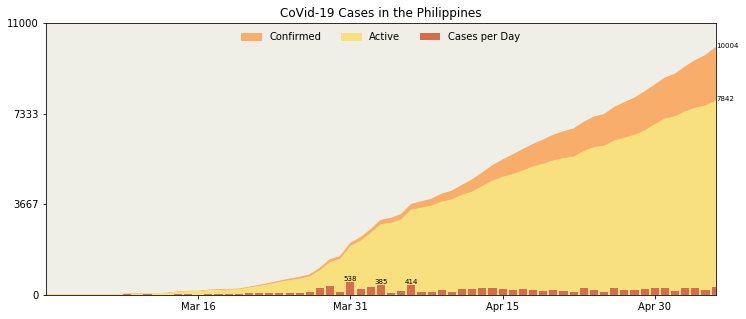

In [31]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_facecolor('#F0EFE7')
plt.title('CoVid-19 Cases in the Philippines')
plt.fill_between(day_case.index.date, day_case['Confirmed'].cumsum(),
                 (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum())),
                 label='Confirmed',
                 color='#f9ad6a')
plt.annotate('%0.f' % day_case['Confirmed'].cumsum()[-1],
             xy=(1, day_case['Confirmed'].cumsum()[-1]),
             xytext=(1, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize= 7)
plt.fill_between(day_case.index.date,
                 (day_case['Confirmed'].cumsum() - (day_case['Death'].cumsum() + day_case['Recovered'].cumsum())), 0,
                 label='Active',
                 color='#f9e07f')
plt.annotate('%0.f' % (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum()))[-1],
             xy=(1, (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum()))[-1]),
             xytext=(1, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize= 7)
ax.bar(day_case.index.date, day_case['Confirmed'],
       label='Cases per Day',
       color='#d46c4e')
for i in range(3):
    plt.annotate('%0.f' % annotate_bars['Confirmed'][i],
                 xy=(annotate_bars.index[i], annotate_bars['Confirmed'][i]),
                 xytext=(-6.5,1),
                 xycoords=('data', 'data'), textcoords='offset points', fontsize=7, color='#000000')
plt.xlim(day_case.index[12],day_case.index[-1])
plt.xticks([day_case.index[20], day_case.index[-1]])
plt.ylim(0,np.ceil((day_case['Confirmed'].cumsum()[-1])/1000)*1000)
ax.yaxis.set_major_locator(ticker.MultipleLocator((np.ceil((day_case['Confirmed'].cumsum()[-1])/1000)*1000)/3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
plt.xlim(pd.Timestamp('2020-03-01'), day_case.index[-1])
plt.xticks(pd.date_range(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1),
                         freq='15D', closed='right'))
plt.legend(loc='upper center',
           ncol=3,
           fontsize=10,
           frameon=False)

## Are we flattening the curve?

The orange graph above is the usual graph we're seeing from the different news agencies, the cummulative number of cases we have everyday. This graph alone won't tell us anything if we are indeed flattening the curve. What we can analyze from it is that more than two weeks after an Enhanced Community Quarantine was enforced in the whole Luzon, the cummulative number of cases stopped from being a steep exponential curve, into a more linear curve. Telling that somehow, we are controlling the growth of cases.

What we should be more concerned about is the yellow area and the orange area. The wider the orange area we see in the graph means more and more cases are being resolved. Unlike the orange graph, the yellow graph can be flattened and this should be the graph we are looking at to see if we are indeed flattening the curve.

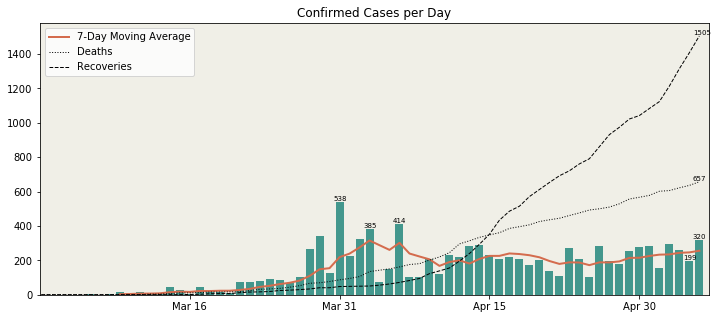

In [32]:
fig2 = plt.figure(figsize=(12,5))
ax = plt.axes()
plt.title('Confirmed Cases per Day')
ax.set_facecolor('#F0EFE7')

ax.bar(day_case.index.date, day_case['Confirmed'],
              color='#43978d')  # was 37AB85
for i in range(5):
    plt.annotate('%0.f' % annotate_bars['Confirmed'][i],
                 xy=(annotate_bars.index[i], annotate_bars['Confirmed'][i]),
                 xytext=(-6.5, 1),
                 xycoords=('data', 'data'), textcoords='offset points', fontsize=7)

plt.plot(day_case.index.date, day_case['Confirmed'].rolling(window= 7).mean(),
         linewidth=2,
         label='7-Day Moving Average',
         color='#d46c4e')  # was FFB052
plt.plot(day_case.index.date, day_case['Death'].cumsum(),
         linestyle= 'dotted',
         linewidth= 1,
         color= '#000000',
         label= 'Deaths')
plt.annotate('%0.f' % day_case['Death'].cumsum()[-1],
             xy=(day_case.index[-1], day_case['Death'].cumsum()[-1]),
             xytext=(-6.5, 1),
             xycoords=('data', 'data'), textcoords='offset points', fontsize= 7)
plt.plot(day_case.index.date, day_case['Recovered'].cumsum(),
         linestyle='--',
         linewidth=1,
         color='#000000',
         label='Recoveries')
plt.annotate('%0.f' % day_case['Recovered'].cumsum()[-1],
             xy=(day_case.index[-1], day_case['Recovered'].cumsum()[-1]),
             xytext=(-6.5, 1),
             xycoords=('data', 'data'), textcoords='offset points', fontsize= 7)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
plt.xlim(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1))
plt.xticks(pd.date_range(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1),
                         freq='15D', closed='right'))
plt.legend(loc='upper left',
           fancybox=True,
           fontsize=10,
           facecolor='#FFFFFF')

The graph above shows our daily cases from March 1. April 15 is a very important date for our country's fight against Covid-19 as this is the day when we have more people who recovered from the disease compared to those who died. There are a lot of issues regarding this data, but we will not concern ourself with those. In the last six days, we had reported the number of cases which are near to each other in values. What we want for this graph is to get the number of cases per day to go smaller and eventually has zero for consecutive days. also, the number of recoveries should continue its exponential growth upward with the number of deaths being minimized to a slow rising linear graph.

## Analysis of Cases Based on Age

Let's look at the extreme cases we had in our country starting from the oldest and youngest confirmed cases. 

In [33]:
print('Oldest Patient is {0} year old {1}, confirmed on {2}.'.format(df['Age'].loc[df['Age'].idxmax()],
                                                                     df['Sex'].loc[df['Age'].idxmax()],
                                                                     df['DateRepConf'].loc[df['Age'].idxmax()].date()))
print('Youngest Patient is {0} year old {1}, confirmed on {2}.'.format(df['Age'].loc[df['Age'].idxmin()],
                                                                       df['Sex'].loc[df['Age'].idxmin()],
                                                                       df['DateRepConf'].loc[df['Age'].idxmin()].date()))
print('Mean age of cases is {0} while median is {1}. Mode is {2}'.format(round(df['Age'].mean()),
                                                                         df['Age'].median(),
                                                                         df['Age'].mode().iloc[0]))

Oldest Patient is 101.0 year old Male, confirmed on 2020-04-06.
Youngest Patient is 0.0 year old Male, confirmed on 2020-04-05.
Mean age of cases is 45.0 while median is 44.0. Mode is 30.0


Let's also look at the extremes and averages for those patients who died.

In [34]:
df_temp = df.loc[df['RemovalType'] == 'Died']
print('Oldest Death is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmax()],
                                                                   df_temp['Sex'].loc[df_temp['Age'].idxmax()],
                                                                   df_temp['DateRepConf'].loc[df_temp['Age'].idxmax()].date()))
print('Youngest Death is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmin()],
                                                                     df_temp['Sex'].loc[df_temp['Age'].idxmin()],
                                                                     df_temp['DateRepConf'].loc[df_temp['Age'].idxmin()].date()))
print('Mean age of deaths is {0} while median is {1}. Mode is {2}'.format(round(df_temp['Age'].mean()),
                                                                          df_temp['Age'].median(),
                                                                          df_temp['Age'].mode().iloc[0]))
df_temp = df_temp[df_temp['DateDied'].notna()]
print('Mean days to die is {0} days.'.format((df_temp['DateDied'] - df_temp['DateRepConf']).mean().days))
print('Mean days to report death is {0} days.'.format((df_temp['DateRepRem'] - df_temp['DateDied']).mean().days))


Oldest Death is 94.0 year old Male, confirmed on 2020-04-10.
Youngest Death is 0.0 year old Male, confirmed on 2020-04-09.
Mean age of deaths is 64.0 while median is 65.0. Mode is 60.0
Mean days to die is -2 days.
Mean days to report death is 11 days.


Currently, most people who died of Covid-19 had died even before it is confirmed that they have the disease. The DOH is also in backlog in terms of reporting deaths.

Let's now look at the extremes and averages for those patients who recovred.

In [35]:
df_temp = df.loc[df['RemovalType'] == 'Recovered']
print('Oldest Recovery is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmax()],
                                                                      df_temp['Sex'].loc[df_temp['Age'].idxmax()],
                                                                      df_temp['DateRepConf'].loc[df_temp['Age'].idxmax()].date()))
print('Youngest Recovery is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmin()],
                                                                        df_temp['Sex'].loc[df_temp['Age'].idxmin()],
                                                                        df_temp['DateRepConf'].loc[df_temp['Age'].idxmin()].date()))
print('Mean age of recoveries is {0} while median is {1}. Mode is {2}'.format(round(df_temp['Age'].mean()),
                                                                              df_temp['Age'].median(),
                                                                              df_temp['Age'].mode().iloc[0]))
df_temp = df_temp[df_temp['DateRecover'].notna()]
print('Mean days to recover is {0} days.'.format((df_temp['DateRecover'] - df_temp['DateRepConf']).mean().days))
print('Mean days to report recovery is {0} days.'.format((df_temp['DateRepRem'] - df_temp['DateRecover']).mean().days))


Oldest Recovery is 89.0 year old Female, confirmed on 2020-03-28.
Youngest Recovery is 0.0 year old Male, confirmed on 2020-04-05.
Mean age of recoveries is 48.0 while median is 48.0. Mode is 31.0
Mean days to recover is 12 days.
Mean days to report recovery is 8 days.


Let's analyze the cases based on their age.

In [36]:
case_age = confirmed_removed_group(df, 'AgeGroup', 'AgeGroup')
target_row = case_age[case_age['AgeGroup'] == '5 to 9'].index.values
idx = [0, target_row] + [i for i in range(1, len(case_age)) if i != target_row]
case_age = case_age.iloc[idx].set_index('AgeGroup').fillna(0)
case_age

,Confirmed,Death,Recovered
AgeGroup,,,
0 to 4,119,3,13
5 to 9,78,1,7
10 to 14,93,1,3
15 to 19,177,4,8
20 to 24,598,3,60
25 to 29,1064,4,137
30 to 34,1255,6,193
35 to 39,854,13,121
40 to 44,774,25,103


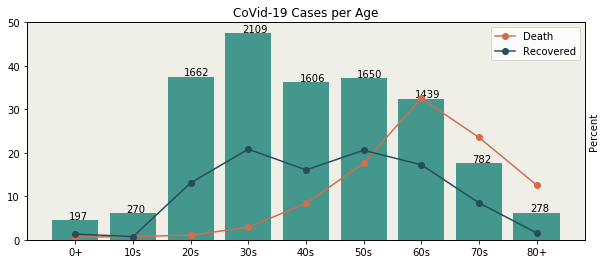

In [37]:
# plot cases per decade
case_age_dec = (case_age + case_age.shift(-1))[:-2:2].append(case_age.iloc[-1]).reset_index()
case_ages_labels = ['0+', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80+']

fig3 = plt.figure(figsize=(10, 4))
ax_count = plt.axes()
plt.title('CoVid-19 Cases per Age')
ax_count.set_facecolor('#F0EFE7')

ax_count.bar(case_age_dec.index, case_age_dec['Confirmed'],
             label='Confirmed',
             color='#43978d')

for i in range(len(case_age_dec)):
    ax_count.annotate('%0.f' % case_age_dec['Confirmed'][i],
                      xy=(case_age_dec.index[i], case_age_dec['Confirmed'][i]),
                      xytext=(-6.5, 1),
                      xycoords=('data', 'data'),
                      textcoords='offset points',
                      fontsize=10)

ax_count.yaxis.set_visible(False)

ax_percent = ax_count.twinx()

ax_percent.plot(case_age_dec.index, (case_age_dec['Death']/case_age_dec['Death'].sum())*100,
                marker='o',
                label='Death',
                color='#d46c4e')
ax_percent.plot(case_age_dec.index, (case_age_dec['Recovered']/case_age_dec['Recovered'].sum())*100,
                marker='o',
                label='Recovered',
                color='#264d59')
ax_percent.set_xticks(case_age_dec.index)
ax_percent.set_xticklabels(case_ages_labels)
ax_percent.set_ylim(0, 50)
ax_percent.yaxis.set_ticks_position('left')
ax_percent.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax_percent.set_ylabel('Percent')
ax_percent.set_xlabel('Age Group')
plt.legend()

The graph shows the distribution of cases per decade of age. It tallies with the mean, median and mode we got above. It can be seen that although most the cases are spread at the ages 20 to 70, the top two age group are those in 20s and 30s. Let's look closer at the timeframes on when these cases happened relative to each other.

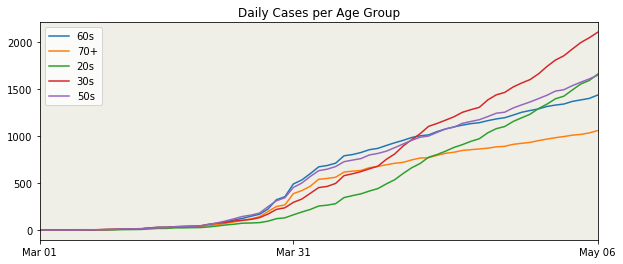

In [38]:
daily_age = df[['DateRepConf', 'AgeGroup']]
daily_age = pd.DataFrame(daily_age.groupby(['DateRepConf', 'AgeGroup']).size().reset_index(name='count'))
daily_age = daily_age.pivot(index='DateRepConf', columns='AgeGroup', values='count').rename_axis(None).fillna(0)
daily_age_chart = pd.DataFrame(daily_age[['60 to 64', '65 to 69']].sum(axis=1), columns=['60s'])
daily_age_chart['70+'] = daily_age[['70 to 74', '75 to 79', '80+']].sum(axis=1)
daily_age_chart['20s'] = daily_age[['20 to 24', '25 to 29']].sum(axis=1)
daily_age_chart['30s'] = daily_age[['30 to 34', '35 to 39']].sum(axis=1)
daily_age_chart['50s'] = daily_age[['50 to 54', '55 to 59']].sum(axis=1)


fig5 = plt.figure(figsize=(10, 4))
ax = plt.axes()
plt.title('Daily Cases per Age Group')
ax.set_facecolor('#F0EFE7')

ax.plot(daily_age_chart.index.date, daily_age_chart.cumsum())
ax.set_xlim(pd.Timestamp('2020-03-01'), daily_age_chart.index[-1])
ax.set_xticks([pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-31'), daily_age_chart.index[-1]])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))

plt.legend(daily_age_chart.columns, loc='upper left')

The graph above shows how the cases evolved over time for the 5 age group. As we can see, the cases for those in their 50s and above almost follows the same shape as the overall cases for the country, while those for ages 20 to 39 rose up since March 31. Early on in this pandemic, the DOH is prioritizing those people in 'vulnerable' sector and age is one of their criteria. There is even a widespread belief that the older you get, the more you are likely to acquire the disease. The rise of cases from those in their 20s and 30s coincides to the time when testing kits are made available to more people and age was removed from the criteria. It just shows that everyone has the same probability of acquiring the disease regardless of their age.

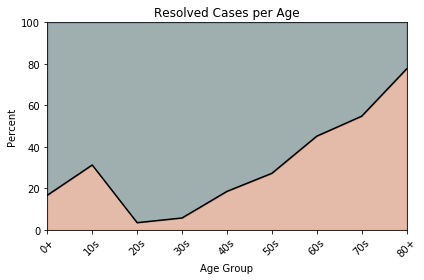

In [39]:
fig4 = plt.figure(figsize=(6, 4))
ax = plt.axes()
plt.title('Resolved Cases per Age')
ax.set_facecolor('#F0EFE7')

div_line = (case_age_dec['Death']/(case_age_dec['Death'] + case_age_dec['Recovered']) * 100)
ax.plot(case_age_dec.index, div_line, color='#000000')
ax.fill_between(case_age_dec.index, 100, div_line, alpha=0.4, color='#264d59')
ax.fill_between(case_age_dec.index, div_line, 0, alpha=0.4, color='#d46c4e')
ax.set_ylim(0, 100)
ax.set_xticklabels(case_ages_labels, rotation='45')
ax.set_xticks(case_age_dec.index)
ax.set_ylabel('Percent')
ax.set_xlabel('Age Group')
# ax.xaxis.set_major_locator(case_age.index)
ax.set_xlim(case_age_dec.index[::len(case_age_dec) - 1])
plt.tight_layout()

If age doesn't matter when it comes to acquiring the disease, it is a different story in terms of how cases were resolved. In the figure above, there is a notable difference in the percentage of patients who recover compared to those who died between the younger and older spectrum of our population. The oldest patients even die about 80% of the time. Children and teenagers also shows to be more likely to succumb to the disease compared to those in their 20s and 30s.

## Testing

DOH keeps a different file on reporting their testing. Let's load it and plot the number of unique individual tested per day.

In [40]:
df = pd.read_csv('datafiles\doh\DOH COVID Data Drop_ 20200506 - 08 Testing Aggregates.csv',
                 parse_dates=['Date'], thousands=',')

df.head(5)

,Date,Name of Health Facility/Laboratory,Abbrev of Health Facility,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,% positive/ unique individuals,NEGATIVE INDIVIDUALS,% negative/ unique individuals,EQUIVOCAL,% equivocal /unique individuals,INVALID,% invalid /unique individuals,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS
0,2020-04-02,Research Institute for Tropical Medicine (RITM),RITM,NaN,NaN,NaN,15197,2652,17%,11367,75%,32,0.20%,NaN,NaN,20826,75396
1,2020-04-02,Baguio General Hospital and Medical Center (BG...,BGHMC,NaN,NaN,NaN,473,21,4%,452,96%,0,0.00%,NaN,NaN,478,4519
2,2020-04-02,San Lazaro Hospital (SLH),SLH,NaN,NaN,NaN,115,31,27%,84,73%,0,0.00%,NaN,NaN,193,4846
3,2020-04-02,Vicente Sotto Memorial Medical Center (VSMMC),VSMMC,NaN,NaN,NaN,672,37,6%,634,94%,1,0.10%,NaN,NaN,672,23812
4,2020-04-02,UP National Institutes of Health (UP-NIH),UP-NIH,NaN,NaN,NaN,332,43,13%,279,84%,10,3.00%,NaN,NaN,335,4565


In [41]:
columns = [col for col in df.columns if col not in ['Name of Health Facility/Laboratory', 'Abbrev of Health Facility',
                                                    'Date']]
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce', downcast='float')
# df = df.apply(pd.to_numeric, errors='ignore', downcast='float')
test_dates = df.groupby(['Date']).sum() #.reset_index()
test_daily = (test_dates - test_dates.shift(1))[1:]

test_annotations = test_daily.nlargest(3,['UNIQUE INDIVIDUALS TESTED']).append(test_daily.tail(2)).append(test_daily.nsmallest(2,['UNIQUE INDIVIDUALS TESTED']))

In [42]:
def regress_line_time(y):
    x = np.arange(len(y)).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(x, y)  # perform linear regression
    y_pred = linear_regressor.predict(x)  # make predictions
    return y_pred

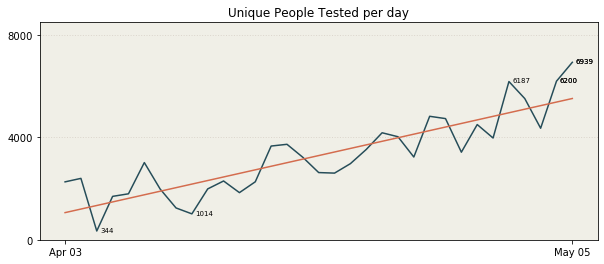

In [43]:
fig7 = plt.figure(figsize=(10, 4))
ax_unique = plt.axes()
plt.title('Unique People Tested per day')
ax_unique.set_facecolor('#F0EFE7')

ax_unique.plot(test_daily.index, test_daily['UNIQUE INDIVIDUALS TESTED'], color='#264d59')
for i in range(len(test_annotations)):
    ax_unique.annotate('%0.f' % test_annotations['UNIQUE INDIVIDUALS TESTED'][i], 
                        xy=(test_annotations.index[i], test_annotations['UNIQUE INDIVIDUALS TESTED'][i]),
                        xytext=(3.5, -1),
                        xycoords=('data', 'data'), textcoords='offset points', fontsize=7)

regress_line = regress_line_time(test_daily['UNIQUE INDIVIDUALS TESTED'].values.reshape(-1, 1))
ax_unique.plot(test_daily.index, regress_line, color='#d46c4e')
ax_unique.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
ax_unique.set_xticks([test_daily.index[0], test_daily.index[-1]])
ax_unique.set_ylim(0, 8500)
ax_unique.set_yticks([0, 4000, 8000])
ax_unique.grid(axis='y', color='#dcd6cd', linestyle='dotted', linewidth=1)

Overall, we are generally increasing the number of individuals being tested as shown by the upward movement of the red regression line. However, we are still a long way from the target 8000 people tested daily. News says that four new megaswabbing facilities will be upped within the month that can bring the number close to 30,000 individuals tested per day.